<h2>Python R code analysis</h2>

<h4><u>Parsing and beautifing data</u></h4>

In [ ]:
# Install and load the necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import re
import numpy as np
from scipy.stats import kurtosis, skew
from statsmodels.robust.scale import mad
from matplotlib import ticker
from FieldClassificationType import FieldClassificationType
from Multivalue import Multivalue
from Policies import Policies

Utils

Should we create an utils class/file ?

In [ ]:
def removeEmptyStrings(df: pd.DataFrame) -> None:
    df.replace('', np.nan, inplace=True)

def get_field_metadata(field_name:str, classification_metadata: dict[str, dict[str, str]]) -> dict[str, str]:
    return classification_metadata[field_name]

def process_splitted_values(values: pd.Series, multiple: str):
    if (multiple):
        return values.apply(lambda x: [item.strip() for item in re.split(rf'\{Multivalue.SEPARATOR.value}', x)])

    return values.apply(lambda x: [x])

Project data objects will not be in JSON files. They will be accessible directly from the relis application environment memory

In [ ]:

with open('../data/relis_classification_rsc_CV.json', 'r', encoding='utf8') as f:
   classification_data: list[dict[str, str]] =  json.loads(f.read())

with open('../data/relis_classification_rsc_metadata_CV.json', 'r', encoding='utf8') as f:
   classification_metadata: dict[str, dict[str, str]] =  json.loads(f.read())

print(classification_data)
print(classification_metadata)

In [ ]:

# Split config file based on data type
def filter_row_by_field_type(paper, field_type):
    pd_row = {key: value["value"] for key, value in paper.items() if value['type'] == field_type}
    return pd_row

nominal_df = pd.DataFrame([filter_row_by_field_type(paper, FieldClassificationType.NOMINAL.value) for paper in classification_data])
continuous_df = pd.DataFrame([filter_row_by_field_type(paper, FieldClassificationType.CONTINUOUS.value) for paper in classification_data])

# For test purpose ?
if (Policies.DROPNA.value):
    removeEmptyStrings(nominal_df)
    removeEmptyStrings(continuous_df)


<h4><u>DESCRIPTIVE STATS</u></h4>

<h5 style="color:orange">Frequency tables<h5>

What do we do with the empty values ? Do they need to be part of the statistics calculation. <br>
Currently, I'll proceed by deleting them in the begining of the file

In [ ]:
def beautify_data_desc(field_name: str, data: pd.DataFrame):
    # Get metadata
    field_metadata = get_field_metadata(field_name, classification_metadata)
    # Split the values by the "|" character and flatten the result
    split_values = process_splitted_values(data[field_name], field_metadata['multiple'])
    flattened_values = np.concatenate(split_values)

    # Generate the frequency table
    freq_table = pd.Series(flattened_values, dtype=str).value_counts().reset_index()
    freq_table.columns = ['value', 'n']

    # Calculate the percentage
    freq_table['percentage'] = (freq_table['n'] / freq_table['n'].sum()) * 100

    return freq_table


desc_distr_vector = {field_name: beautify_data_desc(field_name, nominal_df) for field_name in nominal_df.columns}
print(desc_distr_vector)

What do we do with the empty values ? Do they need to be part of the statistics calculation

<h5 style="color:orange">Bar Plots<h5>

In [ ]:
def generate_bar_plot(field_name: str, data: pd.DataFrame):
    df = beautify_data_desc(field_name, data)
    
    if (len(df) == 0):
        return

    # Set the theme
    sns.set_theme(style="whitegrid")

    # Create the plot
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(data=df, x="value", y="percentage", hue="n")

    # Get metadata
    field_metadata = get_field_metadata(field_name, classification_metadata)

    # Set labels and title
    title = f"{field_metadata['title']} ~ Bar plot"
    barplot.set_title(title)
    barplot.set_xlabel(field_metadata['title'])
    barplot.set_ylabel("Percentage")

    return barplot.figure

bar_plot_vector = {field_name: generate_bar_plot(field_name, nominal_df) for field_name in nominal_df.columns}
print(desc_distr_vector)

<h5 style="color:orange">Statistics
<h5>

In [ ]:
def generate_statistics(field_name: str, data: pd.DataFrame):
    series =  data[field_name]
    # Should be removed if we always drop na initially.
    series.replace('', np.nan, inplace=True)
    
    if (len(data) == 0):
        return

    nan_policy = 'omit' if Policies.DROPNA.value else 'propagate'
    results = {
    "vars": 1,  # Since it's for a single variable
    "n": series.count(),
    "mean": series.mean(),
    "sd": series.std(),
    "median": series.median(),
    "trimmed": series[series.between(series.quantile(0.25), series.quantile(0.75))].mean(),
    "mad": mad(series),  # Mean absolute deviation
    "min": series.min(),
    "max": series.max(),
    "range": series.max() - series.min(),
    "skew": skew(series, nan_policy=nan_policy),
    "kurtosis": kurtosis(series, nan_policy=nan_policy, fisher=True),
    "se": series.std() / np.sqrt(series.count())  
    }
    return results

statistics_vector = {field_name: generate_statistics(field_name, continuous_df) for field_name in continuous_df.columns}
print(statistics_vector)

<h5 style="color:orange">Box Plots<h5>

In [ ]:
def generate_box_plot(field_name: str, data: pd.DataFrame):
    series = data[field_name]

    field_metadata = get_field_metadata(field_name, classification_metadata)

    # Create the box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=series, color='lightblue')

    # Overlay the mean point
    mean_value = series.mean()
    plt.scatter(x=0, y=mean_value, color='red', s=50, zorder=3)  # s is the size of the point

    # Set the title and labels
    title = f"{field_metadata['title']} ~ Box plot"
    plt.title(title)
    plt.ylabel(field_metadata['title'])
    plt.xlabel('')

    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

    # Display the plot
    plt.show()

    return plt

box_plot_vector = {field_name: generate_box_plot(field_name, continuous_df) for field_name in continuous_df.columns}
print(box_plot_vector)

<h5 style="color:orange">Violin Plots<h5>

In [ ]:
def generate_violin_plot(field_name: str, data: pd.DataFrame):
    series = data[field_name]
    
    field_metadata = get_field_metadata(field_name, classification_metadata)

    plt.figure(figsize=(10, 6))
    sns.violinplot(data=series, color="lightgray")

    plt.title(f"{field_metadata['title']} ~ Violin plot")
    plt.ylabel(field_metadata['title'])
    plt.xlabel("Density")
    plt.xticks([])

    plt.show()

violin_plot_vector = {field_name: generate_violin_plot(field_name, continuous_df) for field_name in continuous_df.columns}
print(violin_plot_vector)

<h4><u>EVOLUTIVE STATS</u></h4>

Is Publication.year a classfication field which is mandatory for each of the project ? <br>
It's currently hard coded and doesn't follow any patern.

In [ ]:
def beautify_data_evo(field_name: str, publication_year, data: pd.DataFrame):
    series = data[field_name]

    field_metadata = get_field_metadata(field_name, classification_metadata)
    
    # Create new DataFrame with specified columns
    data = pd.DataFrame({
        'Year': publication_year,
        'Value': process_splitted_values(series, field_metadata['multiple'])
    })
    
    data = data.explode('Value')

    # Remove rows with empty values
    data = data[(data['Value'] != '')]

    data = data.groupby(['Year', 'Value']).size().reset_index(name='Frequency')

    return data

<h5 style="color:pink">Frequency tables<h5>

In [ ]:
def expand_data(field_name: str, publication_year, data: pd.DataFrame):
    data = beautify_data_evo(field_name, publication_year, data)

    # # Pivoting the data
    data = data.pivot(index='Year', columns='Value', values='Frequency').fillna(0)

    data.columns.name = None
    data.reset_index(inplace=True)

    return  data 

violin_plot_vector = {field_name: expand_data(field_name, continuous_df["publication_year"], nominal_df) for field_name in nominal_df.columns}
print(violin_plot_vector)

<h5 style="color:pink">Evolution Plots<h5>

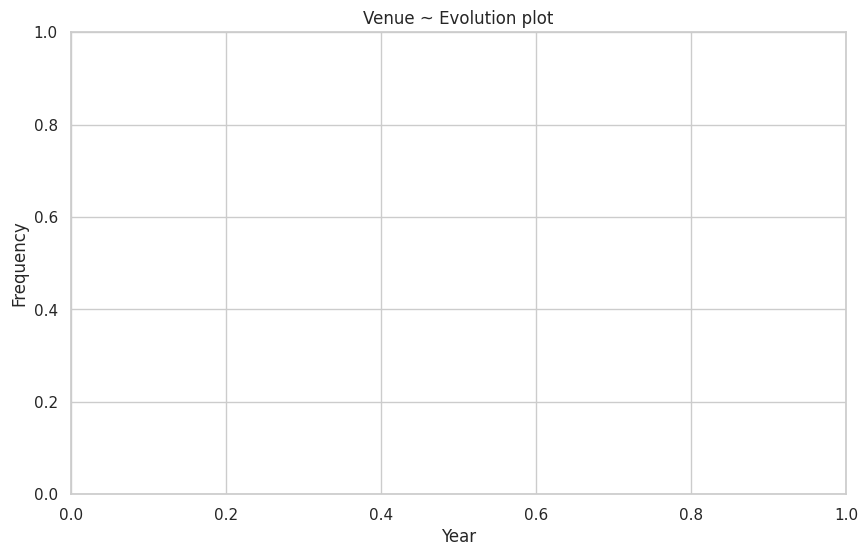

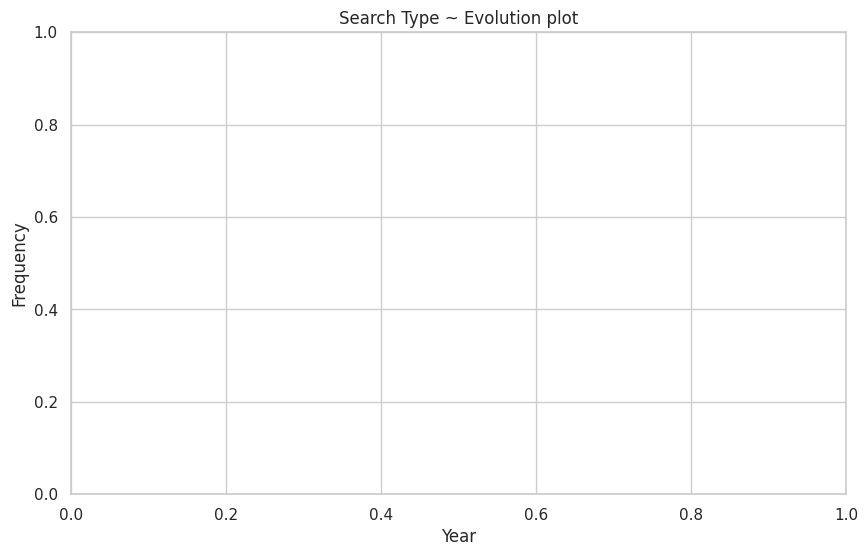

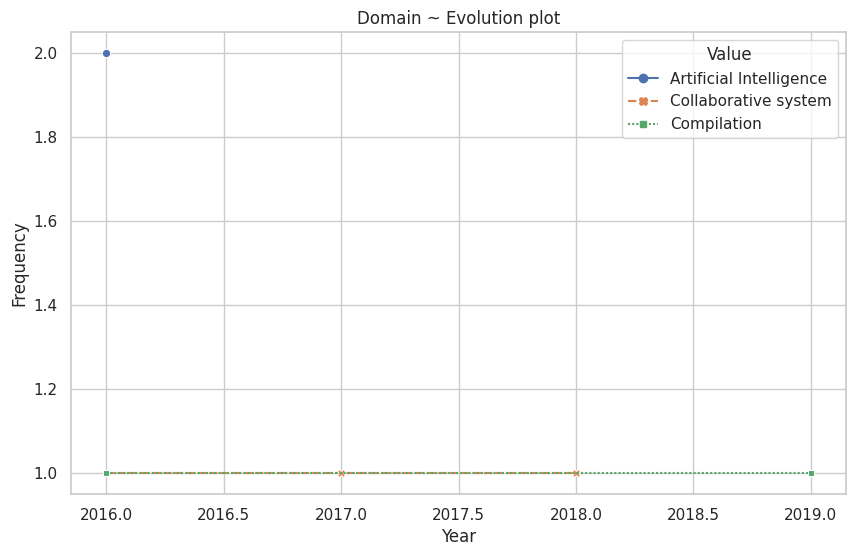

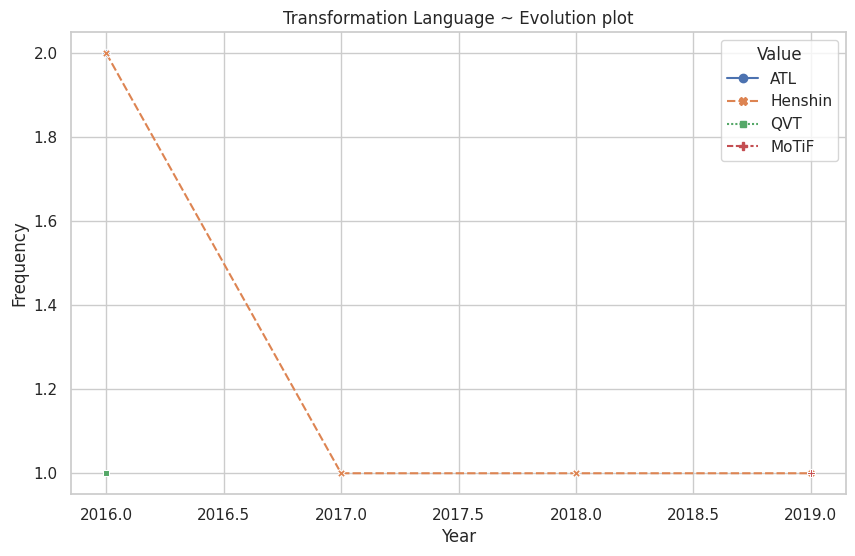

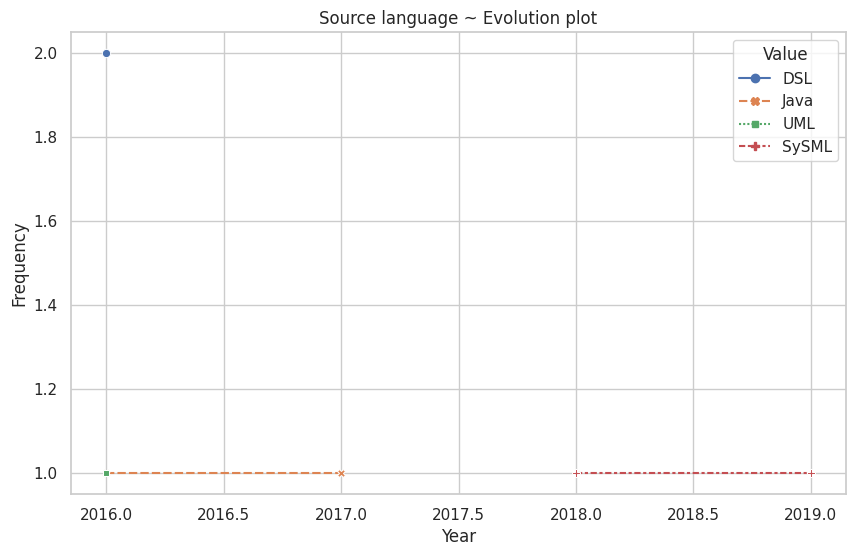

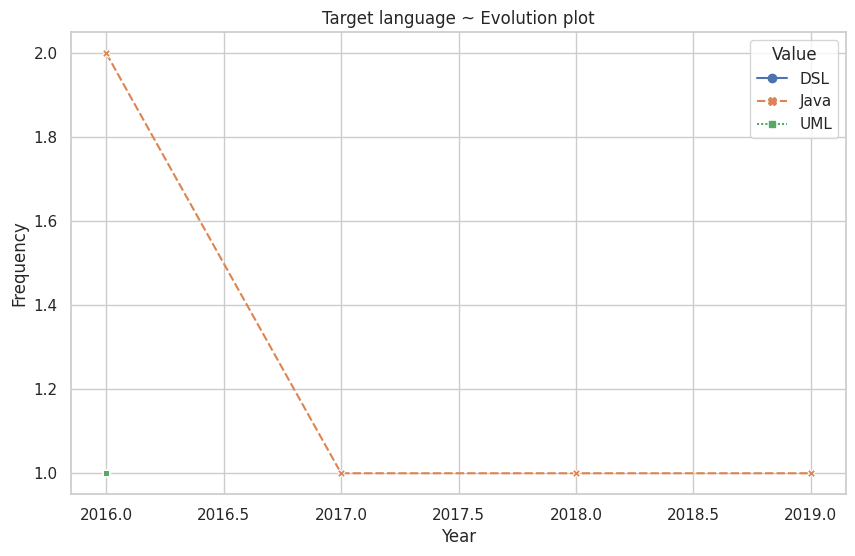

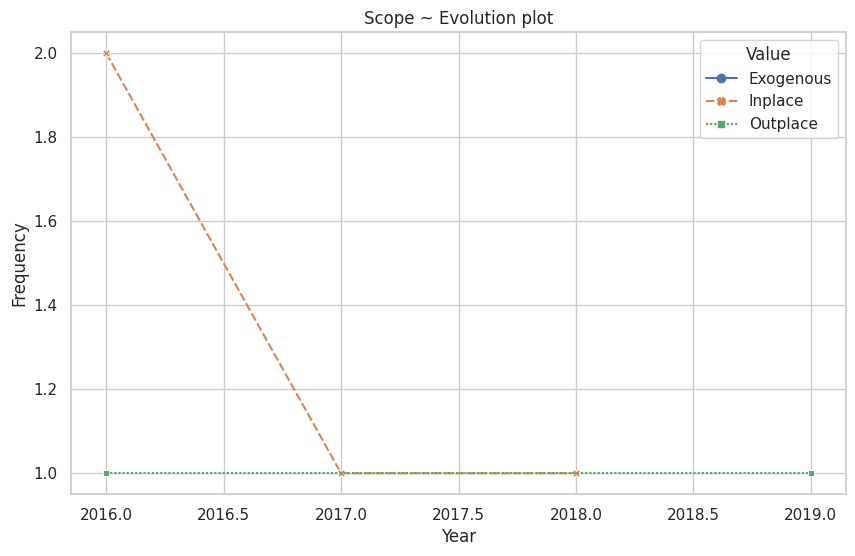

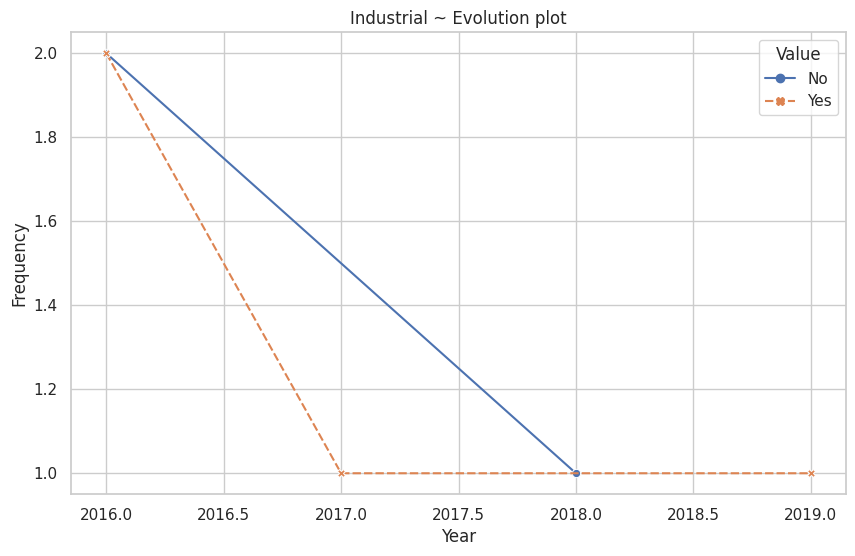

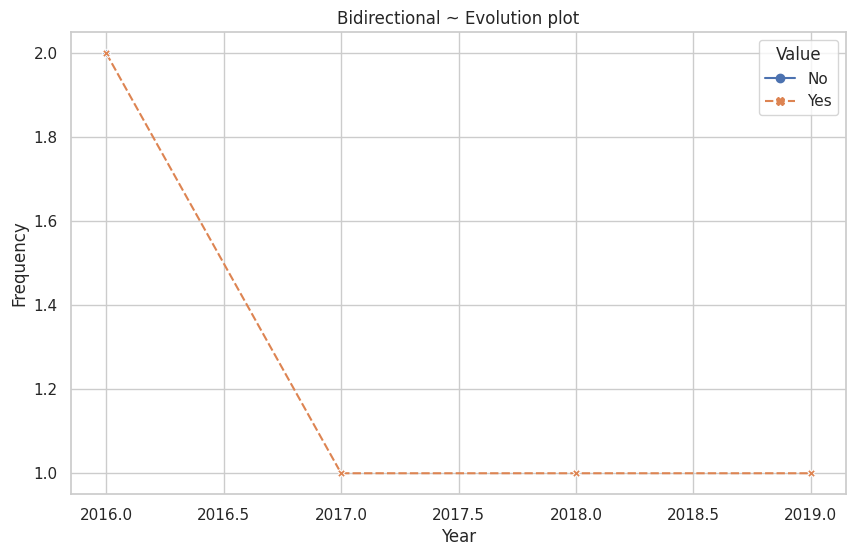

{'venue': None, 'search_type': None, 'domain': None, 'transformation_language': None, 'source_language': None, 'target_language': None, 'scope': None, 'industrial': None, 'bidirectional': None}


In [18]:
def generate_evo_plot(field_name: str, publication_year, data: pd.DataFrame):
    data = beautify_data_evo(field_name, publication_year, data)

    field_metadata = get_field_metadata(field_name, classification_metadata)

    # Create a plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x='Year', y='Frequency', hue='Value', style='Value', markers=True)

    # Setting title, labels, and theme
    plt.title(f"{field_metadata['title']} ~ Evolution plot")
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

evolution_plot_vector = {field_name: generate_evo_plot(field_name, continuous_df["publication_year"], nominal_df) for field_name in nominal_df.columns}
print(evolution_plot_vector)